# Statistical analysis of the data

## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='notebook', rc={'figure.figsize':(25,20)})

from minepy import pstats

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
import umap



top_dir = '/Users/diego/projects/itesoS3/machine-learning/machine-learning-s3'
NUM_CLASSES = 'two-classes'
ph2_labels_path = top_dir+f"/data/processed/ph2/{NUM_CLASSES}/ph2_parquet_files"
ph3_labels_path = top_dir+f"/data/processed/ph3/{NUM_CLASSES}"

In [2]:
# We wrote the data out as parquet files. Let's read them with the use of the pandas library
ph2_data = pd.read_parquet(ph2_labels_path, engine='fastparquet')
ph2_data

,class_numeric,b0x,b0y,b0z,b1x,b1y,b1z,b2x,b2y,b2z,...,v3x,v3y,v3z,mean_x,mean_y,mean_z,person_id,cycle_id,handedness,class
0,0,0.0,-0.0,0.0,-0.019333,-0.012600,0.001643,-0.033223,-0.017726,0.002217,...,0.678694,0.061572,-4.501155,0.344618,0.425332,-0.004384,1,1,0,a
1,0,0.0,-0.0,0.0,-0.018443,-0.012613,0.001769,-0.032238,-0.018307,0.002482,...,0.725780,0.076442,-4.461409,0.344739,0.425745,-0.004810,1,1,0,a
2,0,0.0,-0.0,0.0,-0.020611,-0.011262,0.001664,-0.034579,-0.015002,0.002388,...,0.743553,0.105389,-4.522160,0.344379,0.426648,-0.004969,1,1,0,a
3,0,0.0,-0.0,0.0,-0.020891,-0.009801,0.001665,-0.034945,-0.012790,0.002397,...,0.875916,0.092794,-4.579864,0.343865,0.427672,-0.005253,1,1,0,a
4,0,0.0,-0.0,0.0,-0.020598,-0.010223,0.001704,-0.034461,-0.013555,0.002565,...,0.660163,0.162474,-4.582228,0.343801,0.428773,-0.006244,1,1,0,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3230,1,0.0,0.0,-0.0,-0.003442,-0.019166,0.000959,-0.007385,-0.037069,0.001747,...,-2.268285,1.408503,-12.713003,0.558141,0.287725,-0.014315,9,5,1,b
3231,1,0.0,0.0,-0.0,-0.000505,-0.024086,0.000136,-0.001062,-0.046572,0.000236,...,-14.122936,8.011014,-91.433417,0.557461,0.290157,-0.012749,9,5,1,b
3232,1,0.0,0.0,-0.0,-0.000342,-0.023535,0.000092,-0.000715,-0.044835,0.000160,...,-26.963155,10.592418,-129.377976,0.556638,0.290610,-0.011686,9,5,1,b
3233,1,0.0,0.0,-0.0,-0.000904,-0.023424,0.000250,-0.001879,-0.044744,0.000435,...,-9.208885,4.368271,-49.184478,0.555815,0.289345,-0.012666,9,5,1,b


## Data cleanup

We have no null values in any of our columns already. Also, the date in all the columns we will use to train are model are numeric

In [3]:
ph2_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3235 entries, 0 to 3234
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   class_numeric  3235 non-null   int32   
 1   b0x            3235 non-null   float64 
 2   b0y            3235 non-null   float64 
 3   b0z            3235 non-null   float64 
 4   b1x            3235 non-null   float64 
 5   b1y            3235 non-null   float64 
 6   b1z            3235 non-null   float64 
 7   b2x            3235 non-null   float64 
 8   b2y            3235 non-null   float64 
 9   b2z            3235 non-null   float64 
 10  b3x            3235 non-null   float64 
 11  b3y            3235 non-null   float64 
 12  b3z            3235 non-null   float64 
 13  b4x            3235 non-null   float64 
 14  b4y            3235 non-null   float64 
 15  b4z            3235 non-null   float64 
 16  b5x            3235 non-null   float64 
 17  b5y            3235 non-null   fl

In [4]:
ph2_data.isnull().sum().sum()

0

In [5]:
ph2_data['b0x'].mean()

0.0

## Correlation analysis using different correlation coefficients

### Choosing the numeric columns only

In [6]:
# Selection of the numeric columns
correlation_landmark_col_names = []

# Note that in this section we ignore the coordinates for the wrist because they are always equal to 0:
print(f"wrist x coordinate: mean:{ph2_data['b0x'].mean()}, std:{ph2_data['b0x'].std()}")
print(f"wrist y coordinate: mean:{ph2_data['b0y'].mean()}, std:{ph2_data['b0y'].std()}")
print(f"wrist z coordinate: mean:{ph2_data['b0z'].mean()}, std:{ph2_data['b0z'].std()}")
# This is because we set the wrist as the center of the frame of reference in the transformation in phase 2
# So there is no point in studying the correlation of these three variables with other variables as they are constant
for i in range(1,21):
    correlation_landmark_col_names.append("b"+str(i)+"x")
    correlation_landmark_col_names.append("b"+str(i)+"y")
    correlation_landmark_col_names.append("b"+str(i)+"z")

normal_vector_columns = ['v3x', 'v3y', 'v3z']
center_of_gravity_columns = ['mean_x', 'mean_y', 'mean_z']


corr_numeric_col_names = correlation_landmark_col_names+normal_vector_columns+center_of_gravity_columns+['class_numeric']
corr_numeric_data = ph2_data[corr_numeric_col_names]

wrist x coordinate: mean:0.0, std:0.0
wrist y coordinate: mean:0.0, std:0.0
wrist z coordinate: mean:0.0, std:0.0


### Pearson correlation coefficient

<Axes: >

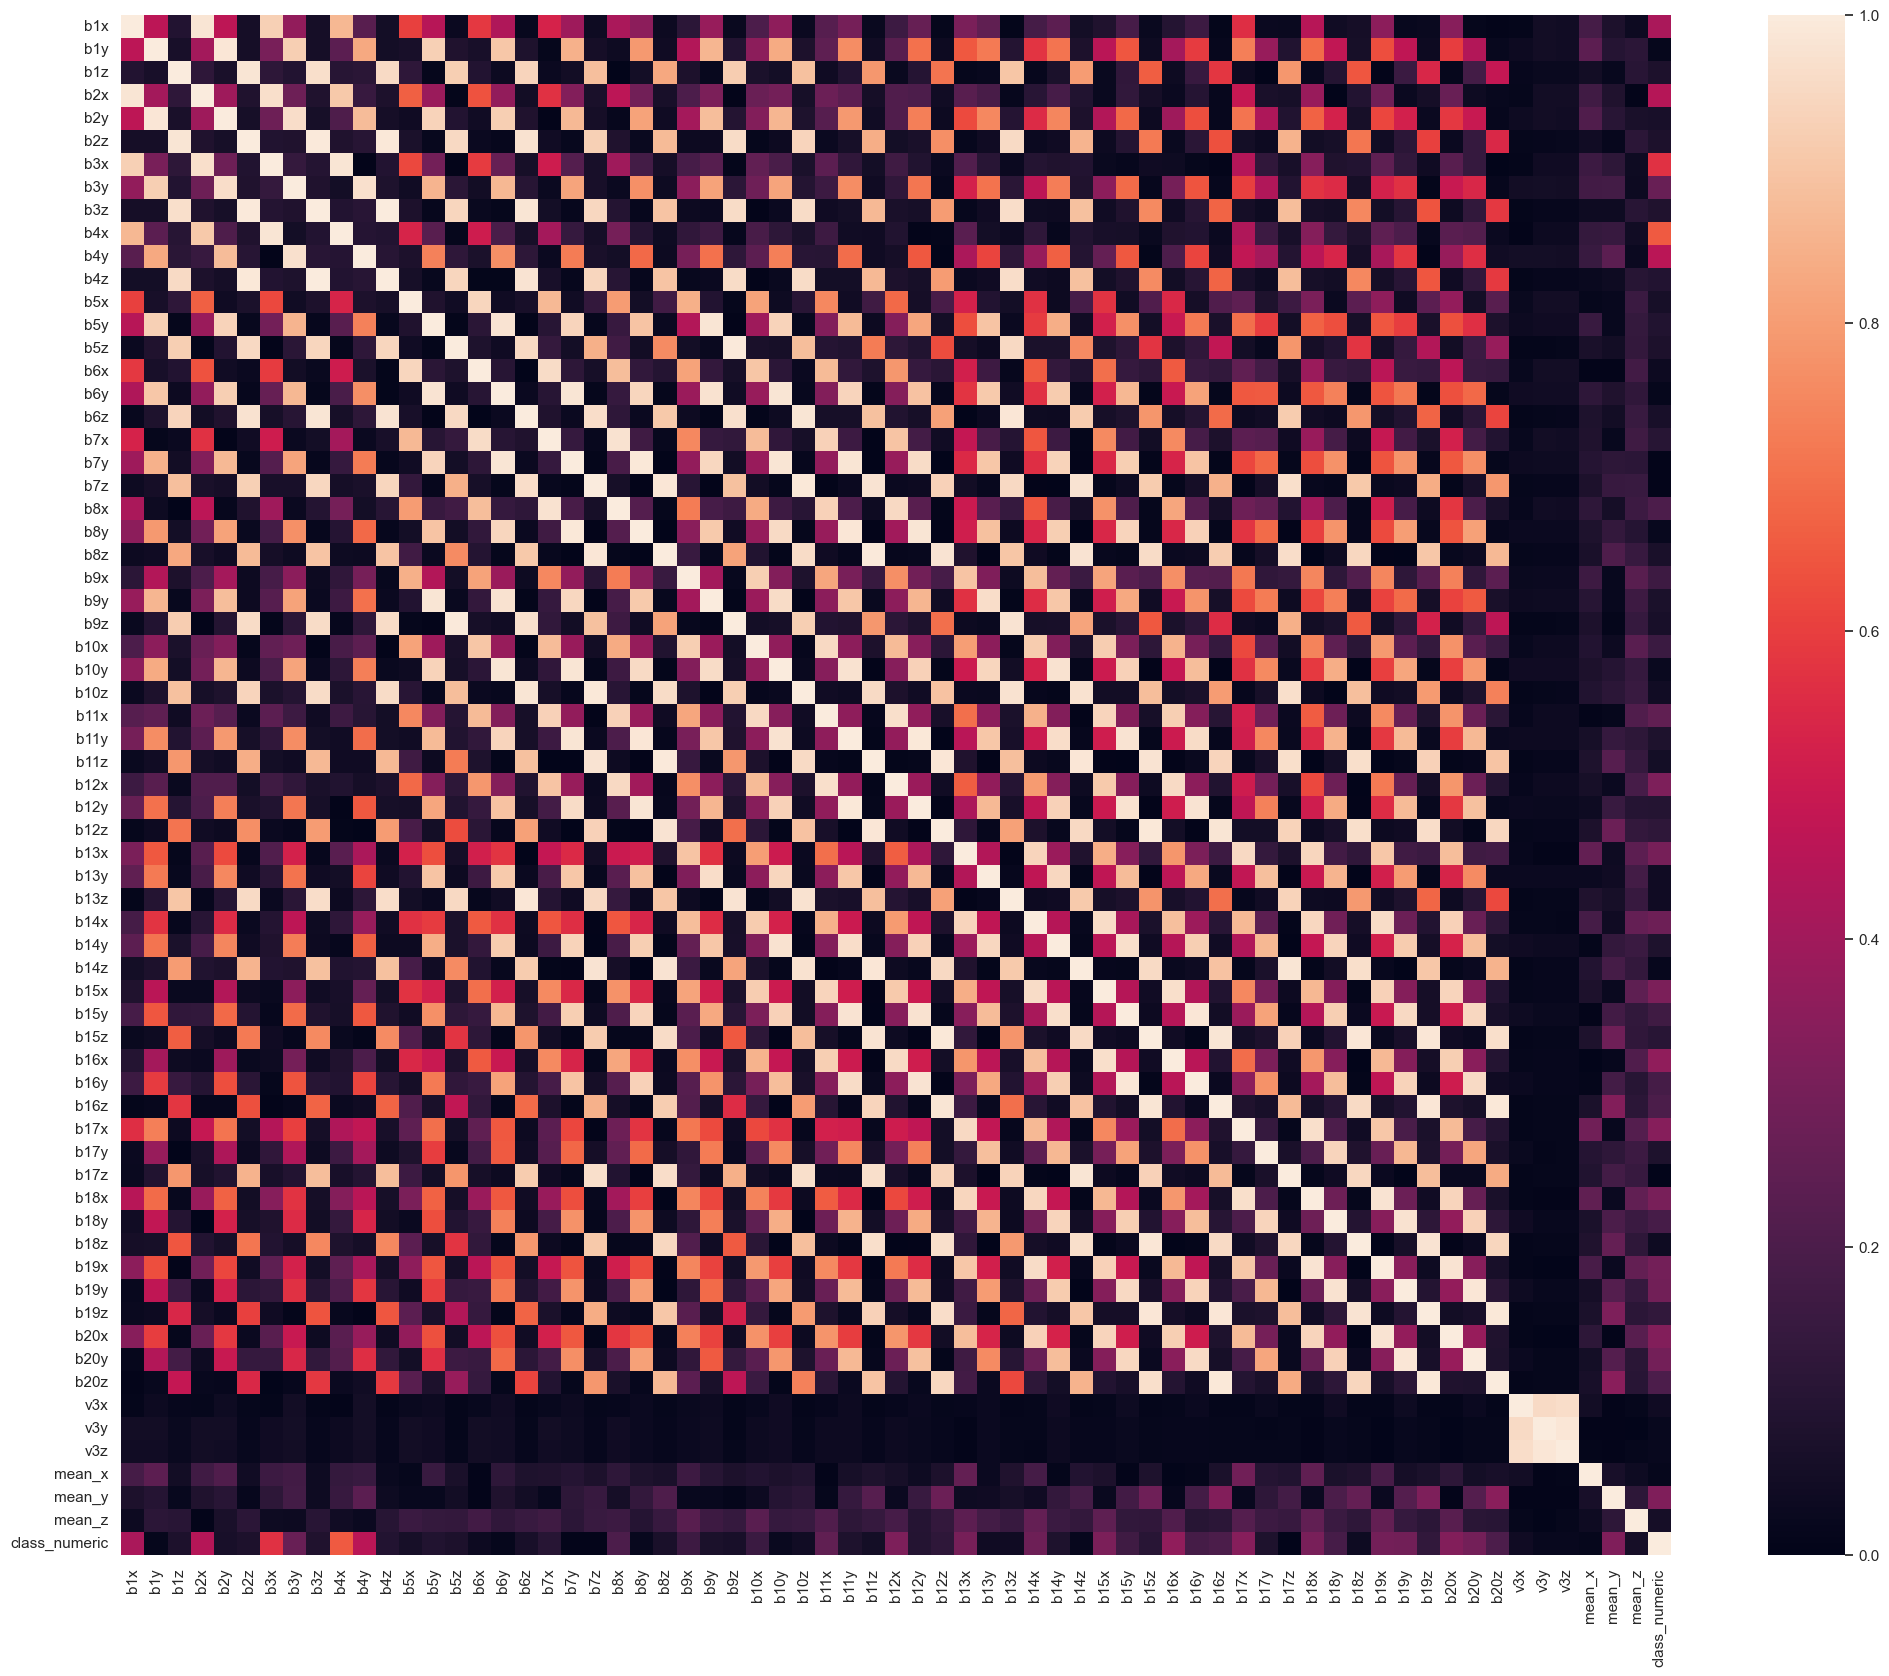

In [7]:
# We use the abs() method to get the absolute value
data_corr_coeffs_pearson = corr_numeric_data.corr('pearson').abs()
sns.heatmap(data=data_corr_coeffs_pearson, vmin=0, vmax=1, xticklabels=corr_numeric_col_names, yticklabels=corr_numeric_col_names)

In [8]:
pearson_arg_ind = data_corr_coeffs_pearson['class_numeric'].head(n=66).argmax()
print(f'using pearson, the variable with the highest correlation with the class is: {ph2_data.keys()[pearson_arg_ind+4]}')

using pearson, the variable with the highest correlation with the class is: b4x


### Kendall Correlation Coefficient

<Axes: >

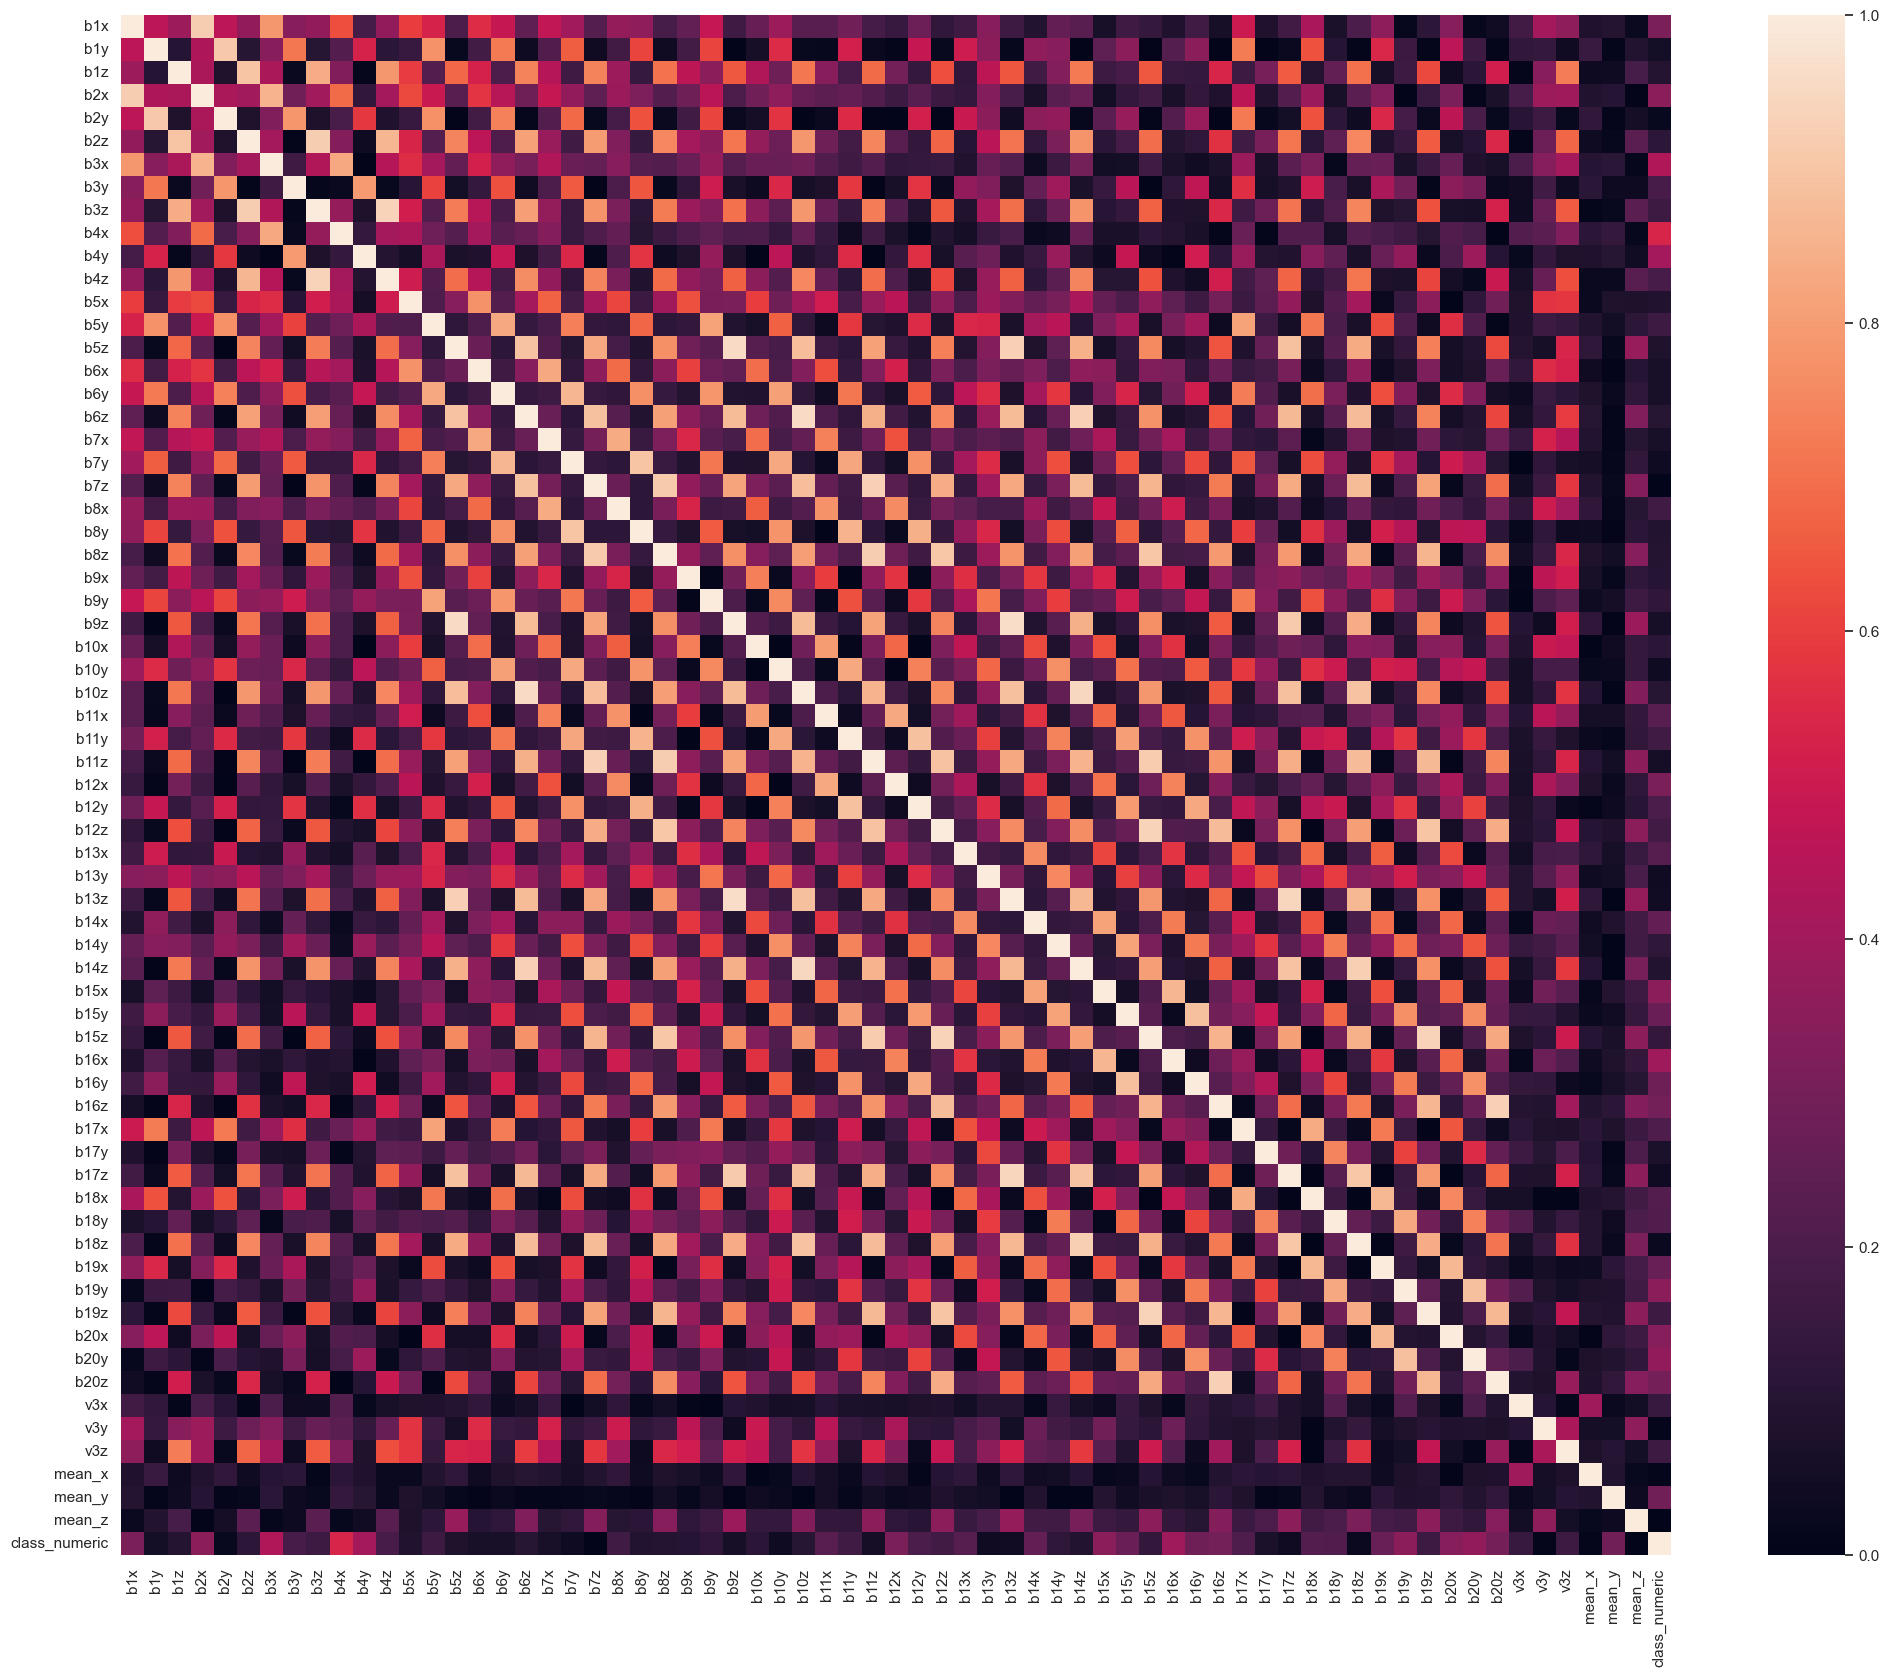

In [9]:
# We use the abs() method to get the absolute value
data_corr_coeffs_kendall = corr_numeric_data.corr('kendall').abs()
sns.heatmap(data=data_corr_coeffs_kendall, vmin=0, vmax=1, xticklabels=corr_numeric_col_names, yticklabels=corr_numeric_col_names)

In [10]:
kendall_arg_ind = data_corr_coeffs_kendall['class_numeric'].head(n=66).argmax() 
print(f'using kendall, the variable with the highest correlation with the class is: {ph2_data.keys()[kendall_arg_ind+4]}')

using kendall, the variable with the highest correlation with the class is: b4x


### Spearman correlation coefficient

<Axes: >

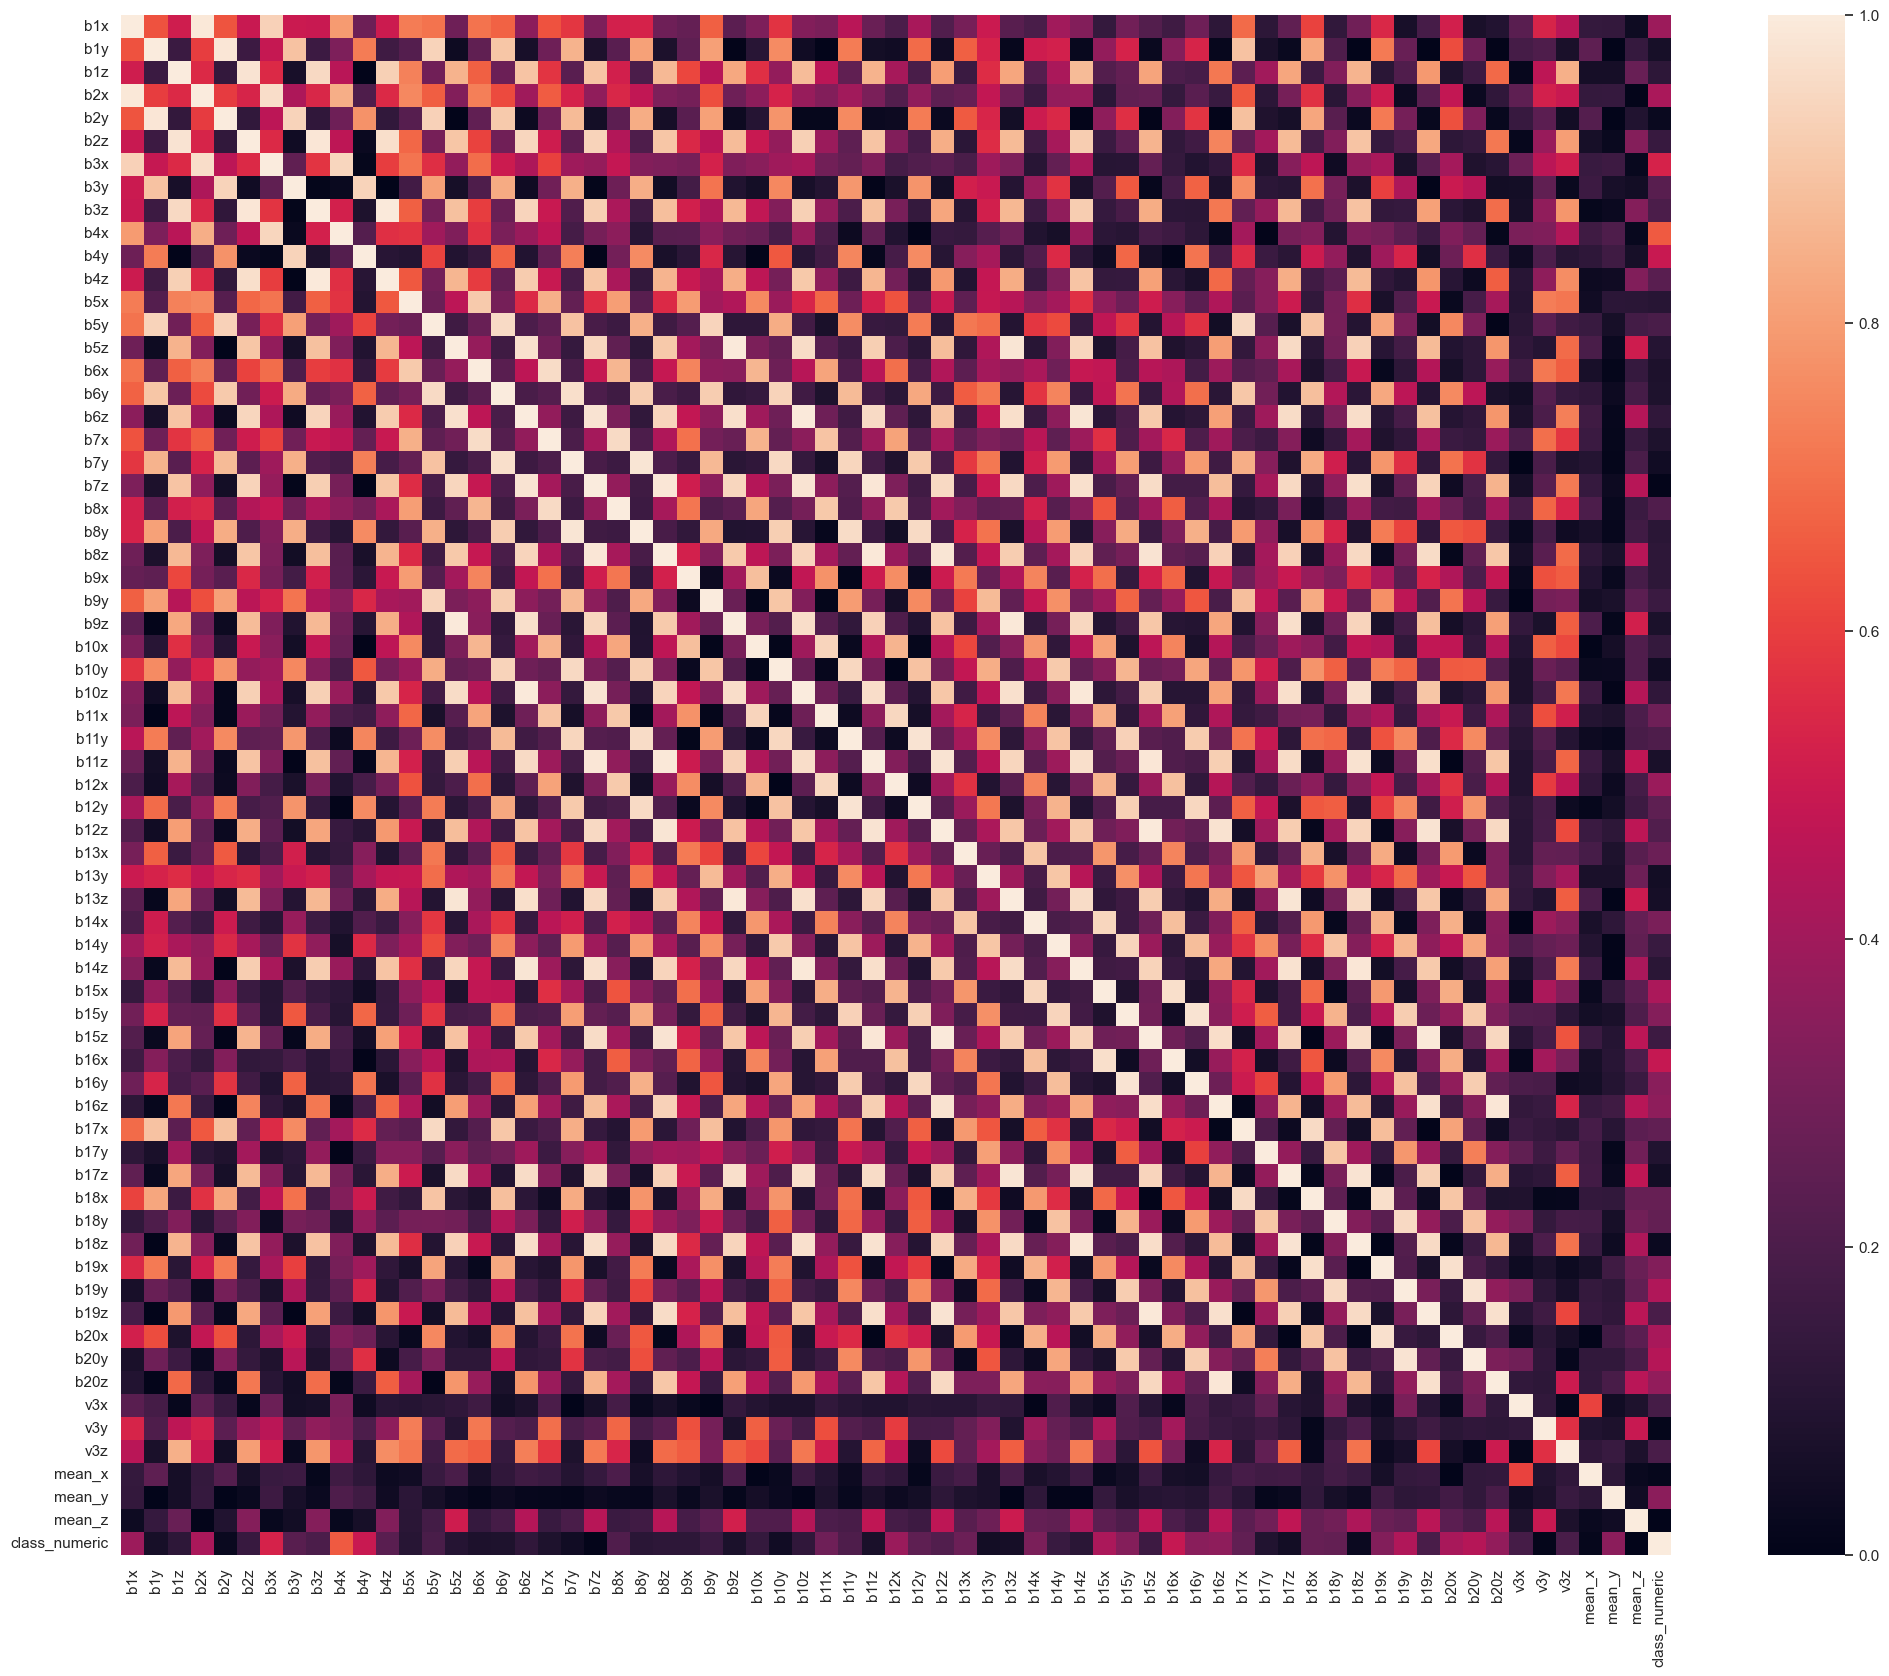

In [11]:
# We use the abs() method to get the absolute value
data_corr_coeffs_spearman = corr_numeric_data.corr('spearman').abs()
sns.heatmap(data=data_corr_coeffs_spearman, vmin=0, vmax=1, xticklabels=corr_numeric_col_names, yticklabels=corr_numeric_col_names)

In [12]:
pearson_arg_ind = data_corr_coeffs_spearman['class_numeric'].head(n=66).argmax()
print(f'using spearman, the variable with the highest correlation with the class is: {ph2_data.keys()[pearson_arg_ind+4]}')

using spearman, the variable with the highest correlation with the class is: b4x


### Maximal Information Coefficient (MIC)

In [13]:
MIC_numeric_col_names = correlation_landmark_col_names+normal_vector_columns+center_of_gravity_columns+['class_numeric']
MIC_numeric_data = ph2_data[MIC_numeric_col_names]

MIC_list, _ = pstats(MIC_numeric_data)

<Axes: >

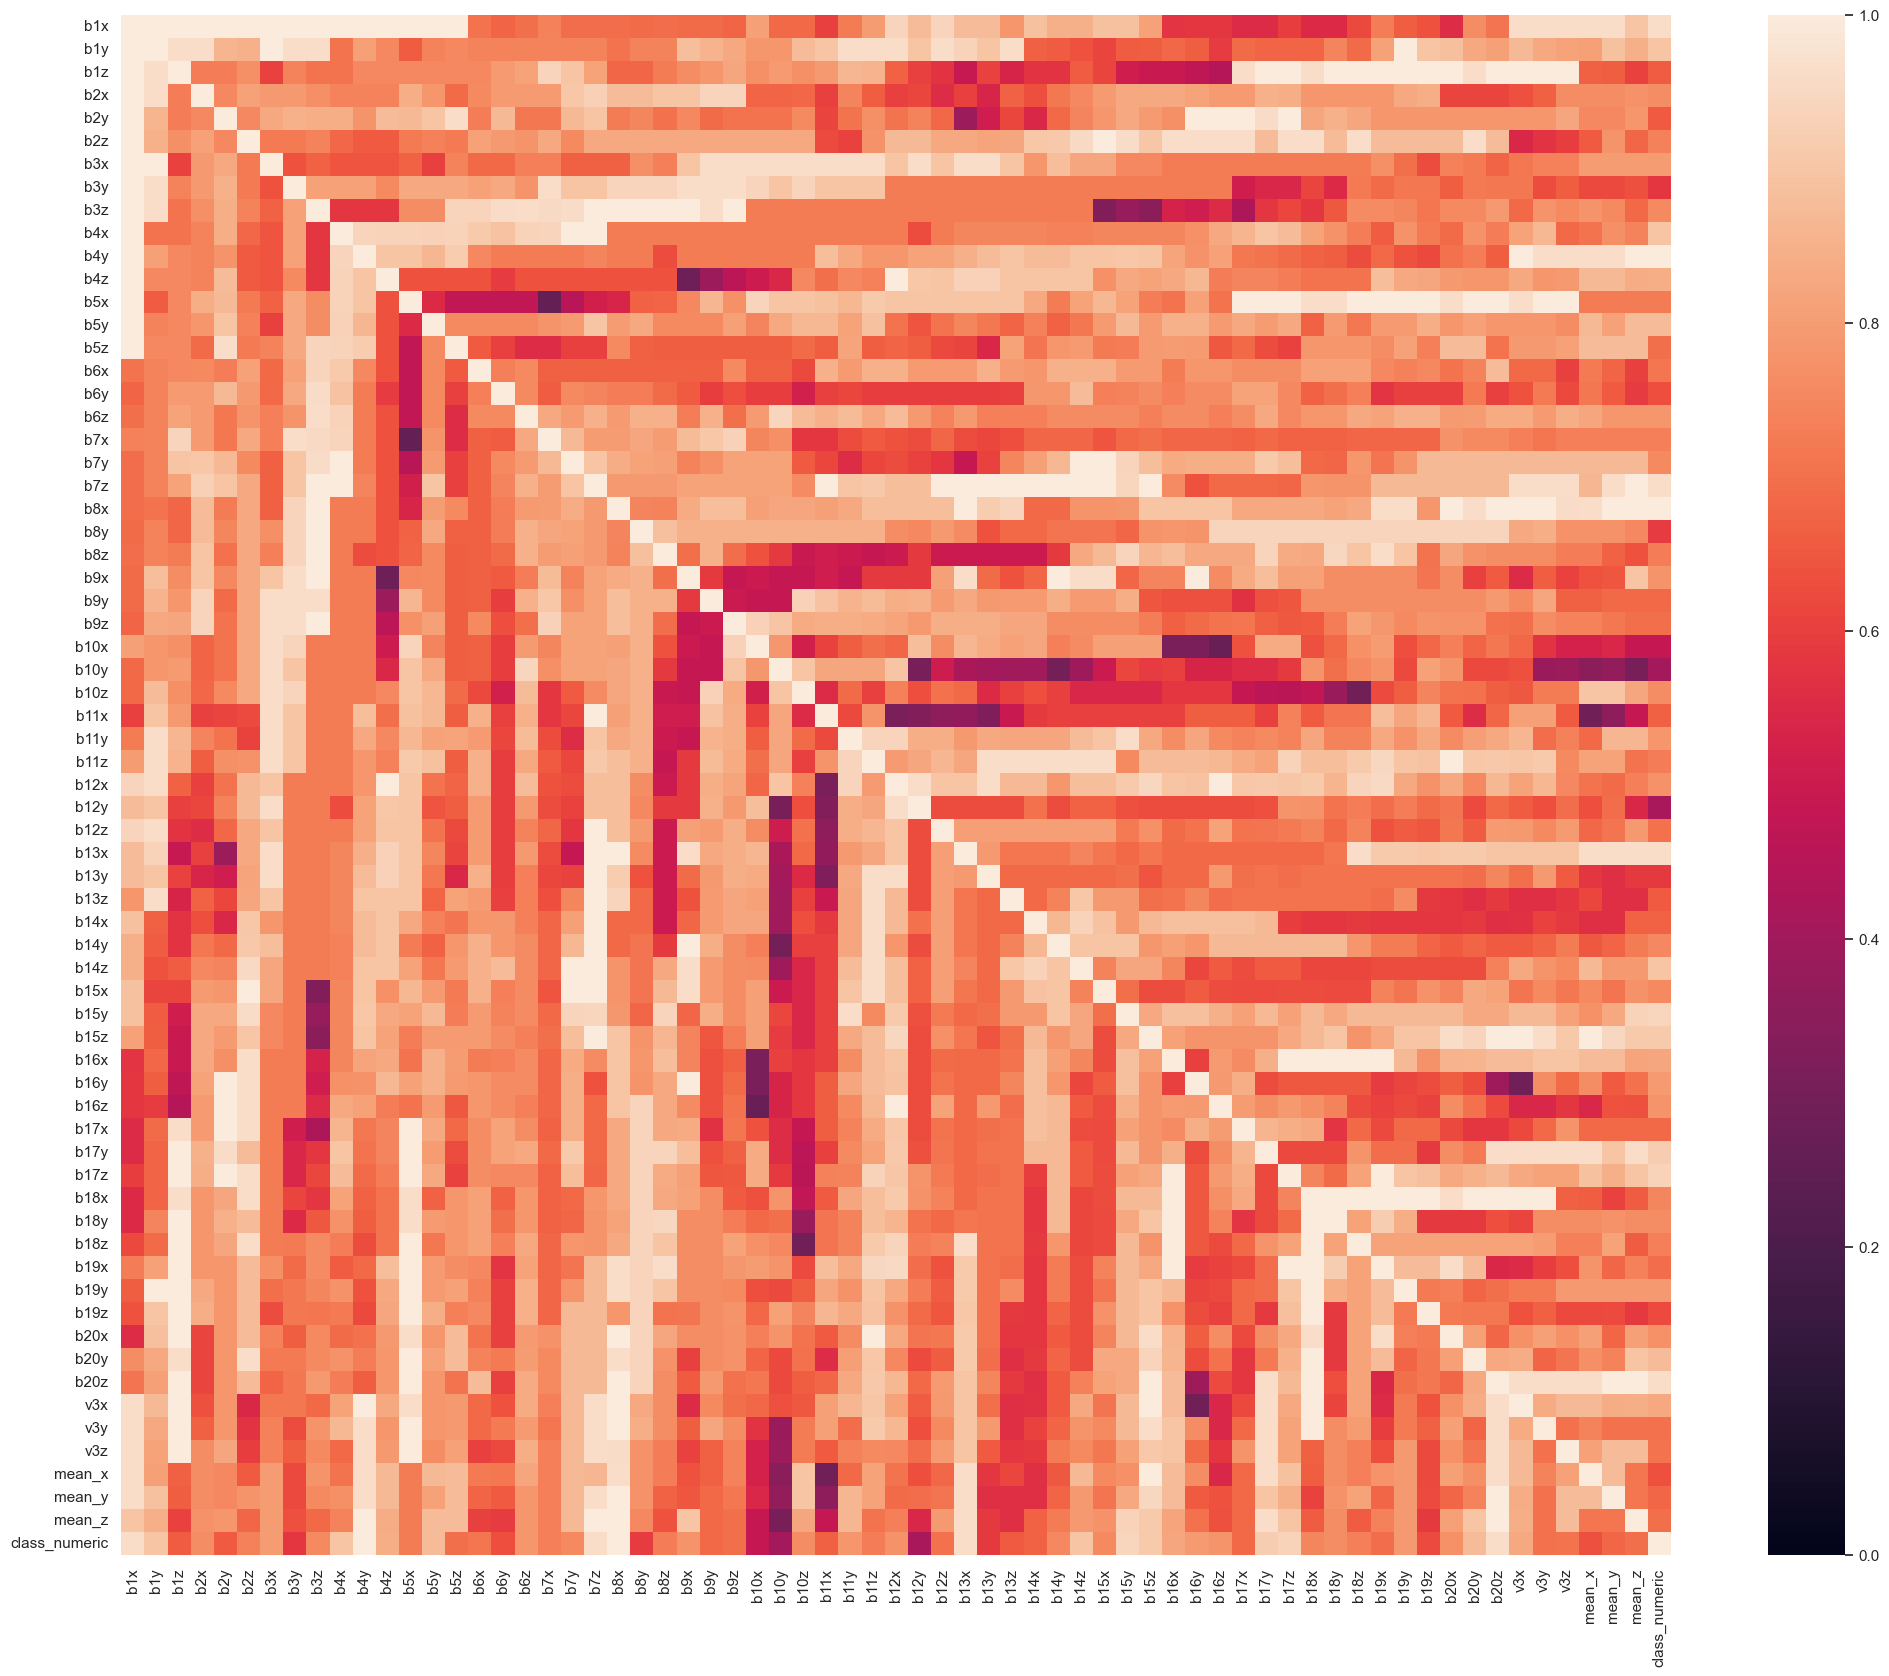

In [14]:
MIC_matrix = [[-1 for _ in MIC_numeric_col_names] for __ in MIC_numeric_col_names]

m = len(MIC_numeric_col_names)

for i in range(m):
    for j in range(m):
        if i > j:
            continue
        elif i == j:
            MIC_matrix[i][j] = 1
        else:
            MIC_matrix[i][j] = MIC_matrix[j][i] = MIC_list[m*i + (j-(i+1))]

sns.heatmap(data=MIC_matrix, vmin=0, vmax=1, xticklabels=MIC_numeric_col_names, yticklabels=MIC_numeric_col_names)

### Correlation analysis conclusions

For two classes, for all three of these correlation metrics, the variable with the highest correlation with the "class_numeric" variable is "b4x", which corresponds to the the x coordinate for the tip of the thumb.

Here are the sings for the letters A and B in Mexican Sign Language:
<div>
<img src="/Users/diego/projects/itesoS3/machine-learning/machine-learning-s3/figures/ab.png" width="600"/>
</div>

As we can see, the thumb is pointing "outwards" for A and "inwards" for B, so this being a very relevant variable makes sense.

As an aside note, notice that even though the "x" coordinate isn't referring to the traditional cartesian coordinate system "x" coordinate, this correlation score indicates that some amount of this same information was kept even after the transformations we made in phase 2 of data preparation. 

# Dimensionality reduction

In [15]:
label_column = 'class_numeric'

ph2_landmark_col_names = []

for i in range(21):
    ph2_landmark_col_names.append("b"+str(i)+"x")
    ph2_landmark_col_names.append("b"+str(i)+"y")
    ph2_landmark_col_names.append("b"+str(i)+"z")

normal_vector_columns = ['v3x', 'v3y', 'v3z']
center_of_gravity_columns = ['mean_x', 'mean_y', 'mean_z']


X = ph2_data[ph2_landmark_col_names + normal_vector_columns + center_of_gravity_columns]
y = ph2_data[label_column]

scaled_X = StandardScaler().fit_transform(X)

## Visualizations

### 2D

In [16]:
# PCA
pca_reducer_2 = PCA(n_components=2)
pca_reduced_2 = pca_reducer_2.fit_transform(scaled_X)

# t-SNE
tsne_reducer_2 = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30)
tsne_reduced_2 = tsne_reducer_2.fit_transform(scaled_X)

# UMAP
umap_reducer_2 = umap.UMAP(n_components=2)
umap_reduced_2 = umap_reducer_2.fit_transform(scaled_X)

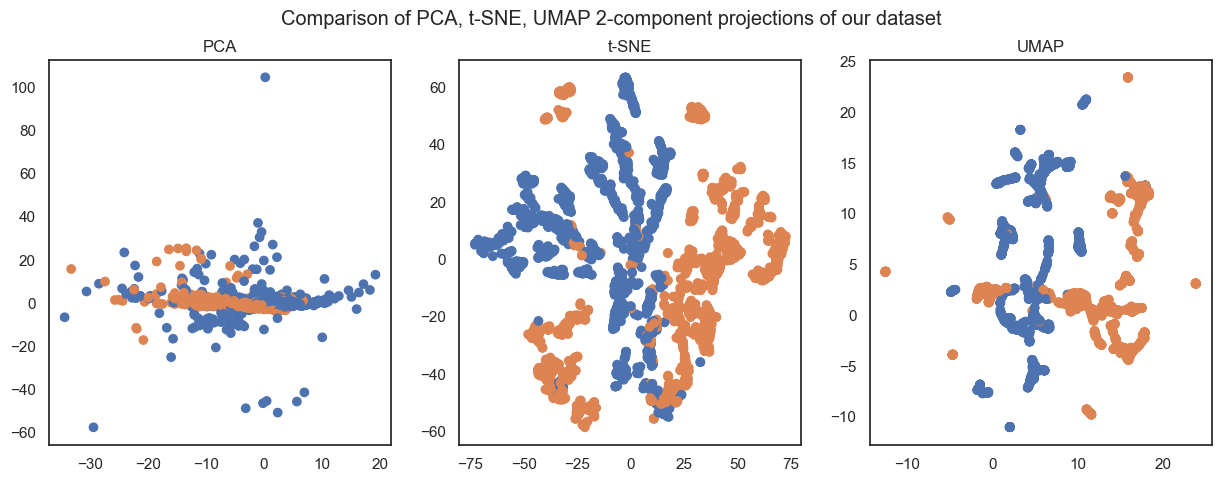

In [17]:
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(15,5)})
fig = plt.figure(1)
plt.suptitle('Comparison of PCA, t-SNE, UMAP 2-component projections of our dataset')

# PCA
pca_ax_2 = fig.add_subplot(1,3,1)
pca_ax_2.scatter(
    pca_reduced_2[:, 0],
    pca_reduced_2[:, 1],
    c=[sns.color_palette()[x] for x in y])
pca_ax_2.set_title("PCA")

# t-SNE
tsne_ax_2 = fig.add_subplot(1,3,2)
tsne_ax_2.scatter(
    tsne_reduced_2[:, 0],
    tsne_reduced_2[:, 1],
    c=[sns.color_palette()[x] for x in y])
tsne_ax_2.set_title("t-SNE")

# UMAP
umap_ax_2 = fig.add_subplot(1,3,3)
umap_ax_2.scatter(
    umap_reduced_2[:, 0],
    umap_reduced_2[:, 1],
    c=[sns.color_palette()[x] for x in y])
umap_ax_2.set_title("UMAP")

plt.show()

In [18]:
# Kernel PCA
## Linear Kernel
lin_kern_pca_reducer_2 = KernelPCA(n_components=2, kernel='linear')
lin_kern_pca_reduced_2 = lin_kern_pca_reducer_2.fit_transform(scaled_X)
## Polynomial Kernel
poly_kern_pca_reducer_2 = KernelPCA(n_components=2, kernel='poly')
poly_kern_pca_reduced_2 = poly_kern_pca_reducer_2.fit_transform(scaled_X)
## RBF Kernel
rbf_kern_pca_reducer_2 = KernelPCA(n_components=2, kernel='rbf')
rbf_kern_pca_reduced_2 = rbf_kern_pca_reducer_2.fit_transform(scaled_X)
## Sigmoid Kernel
sigm_kern_pca_reducer_2 = KernelPCA(n_components=2, kernel='sigmoid')
sigm_kern_pca_reduced_2 = sigm_kern_pca_reducer_2.fit_transform(scaled_X)
## Cosine Kernel
cos_kern_pca_reducer_2 = KernelPCA(n_components=2, kernel='cosine')
cos_kern_pca_reduced_2 = cos_kern_pca_reducer_2.fit_transform(scaled_X)

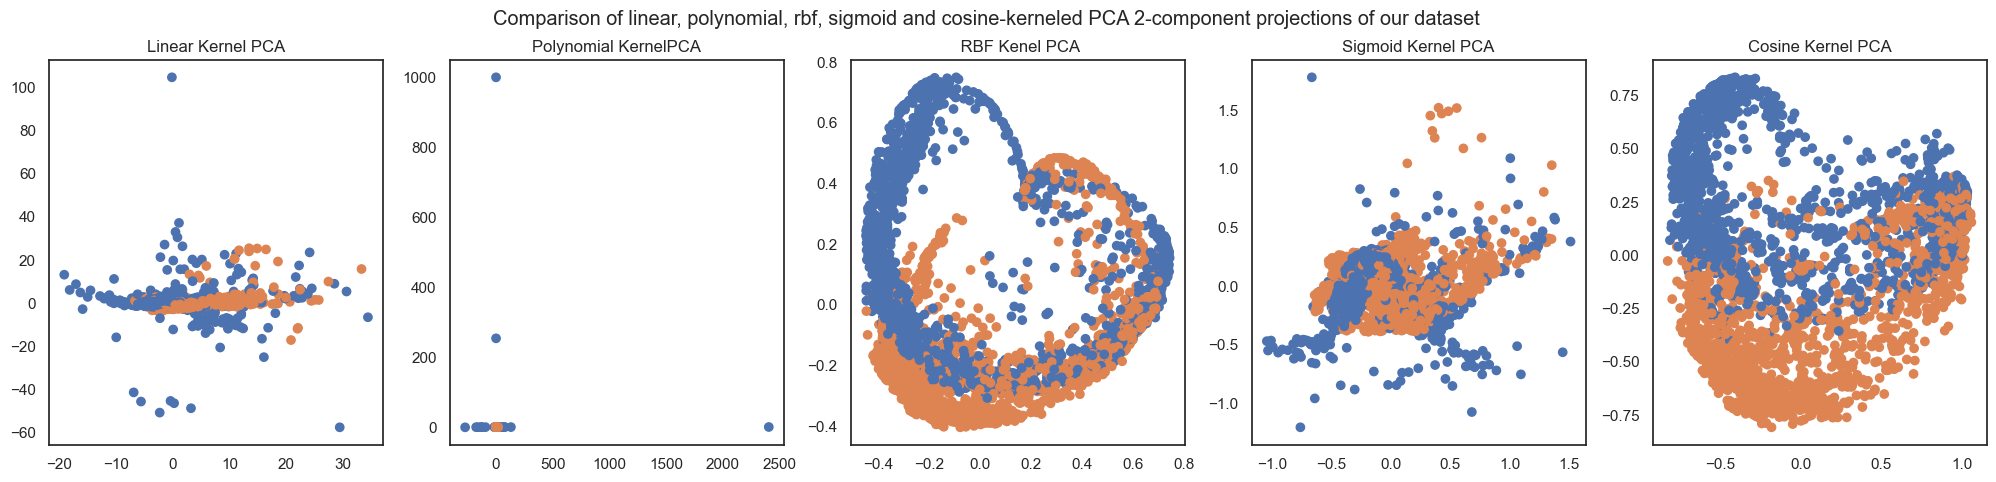

In [19]:
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(25,5)})
fig = plt.figure(2)
plt.suptitle('Comparison of linear, polynomial, rbf, sigmoid and cosine-kerneled PCA 2-component projections of our dataset')

## Linear Kernel
lin_kern_pca_ax_2 = fig.add_subplot(1,5,1)
lin_kern_pca_ax_2.scatter(
    lin_kern_pca_reduced_2[:, 0],
    lin_kern_pca_reduced_2[:, 1],
    c=[sns.color_palette()[x] for x in y])
lin_kern_pca_ax_2.set_title("Linear Kernel PCA")

## Polynomial Kernel
poly_kern_pca_ax_2 = fig.add_subplot(1,5,2)
poly_kern_pca_ax_2.scatter(
    poly_kern_pca_reduced_2[:, 0],
    poly_kern_pca_reduced_2[:, 1],
    c=[sns.color_palette()[x] for x in y])
poly_kern_pca_ax_2.set_title("Polynomial KernelPCA")

## RBF Kernel
rbf_kern_pca_ax_2 = fig.add_subplot(1,5,3)
rbf_kern_pca_ax_2.scatter(
    rbf_kern_pca_reduced_2[:, 0],
    rbf_kern_pca_reduced_2[:, 1],
    c=[sns.color_palette()[x] for x in y])
rbf_kern_pca_ax_2.set_title(" RBF Kenel PCA")

## Sigmoid Kernel
sigm_kern_pca_ax_2 = fig.add_subplot(1,5,4)
sigm_kern_pca_ax_2.scatter(
    sigm_kern_pca_reduced_2[:, 0],
    sigm_kern_pca_reduced_2[:, 1],
    c=[sns.color_palette()[x] for x in y])
sigm_kern_pca_ax_2.set_title("Sigmoid Kernel PCA")

## Cosine Kernel
cos_kern_pca_ax_2 = fig.add_subplot(1,5,5)
cos_kern_pca_ax_2.scatter(
    cos_kern_pca_reduced_2[:, 0],
    cos_kern_pca_reduced_2[:, 1],
    c=[sns.color_palette()[x] for x in y])
cos_kern_pca_ax_2.set_title("Cosine Kernel PCA")

plt.show()

### 3D

In [20]:
# PCA
pca_reducer_3 = PCA(n_components=3)
pca_reduced_3 = pca_reducer_3.fit_transform(scaled_X)

# t-SNE
tsne_reducer_3 = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=30)
tsne_reduced_3 = tsne_reducer_3.fit_transform(scaled_X)

# UMAP
umap_reducer_3 = umap.UMAP(n_components=3)
umap_reduced_3 = umap_reducer_3.fit_transform(scaled_X)

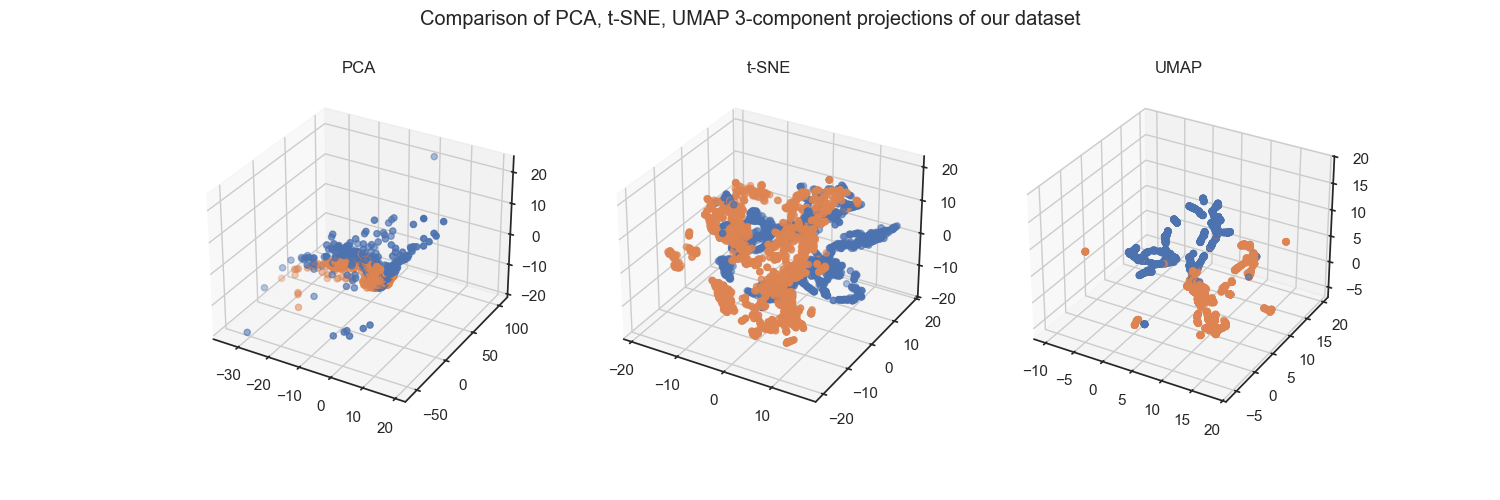

In [21]:
%matplotlib widget
sns.set(style='white', context='notebook', rc={'figure.figsize':(15,5)})
fig = plt.figure(3)
plt.suptitle('Comparison of PCA, t-SNE, UMAP 3-component projections of our dataset')

# PCA
pca_ax_3 = fig.add_subplot(1,3,1, projection='3d')
pca_ax_3.scatter(pca_reduced_3[:, 0], pca_reduced_3[:, 1], pca_reduced_3[:, 2], c=[sns.color_palette()[x] for x in y]) 
pca_ax_3.set_title("PCA")

# t-SNE
tsne_ax_3 = fig.add_subplot(1,3,2, projection='3d')
tsne_ax_3.scatter(tsne_reduced_3[:, 0], tsne_reduced_3[:, 1], tsne_reduced_3[:, 2], c=[sns.color_palette()[x] for x in y]) 
tsne_ax_3.set_title("t-SNE")

# UMAP
umap_ax_3 = fig.add_subplot(1,3,3, projection='3d')
umap_ax_3.scatter(umap_reduced_3[:, 0], umap_reduced_3[:, 1], umap_reduced_3[:, 2], c=[sns.color_palette()[x] for x in y]) 
umap_ax_3.set_title("UMAP")

plt.show()


In [22]:
# Kernel PCA
## Linear Kernel
lin_kern_pca_reducer_3 = KernelPCA(n_components=3, kernel='linear')
lin_kern_pca_reduced_3 = lin_kern_pca_reducer_3.fit_transform(scaled_X)
## Polynomial Kernel
poly_kern_pca_reducer_3 = KernelPCA(n_components=3, kernel='poly')
poly_kern_pca_reduced_3 = poly_kern_pca_reducer_3.fit_transform(scaled_X)
## RBF Kernel
rbf_kern_pca_reducer_3 = KernelPCA(n_components=3, kernel='rbf')
rbf_kern_pca_reduced_3 = rbf_kern_pca_reducer_3.fit_transform(scaled_X)
## Sigmoid Kernel
sigm_kern_pca_reducer_3 = KernelPCA(n_components=3, kernel='sigmoid')
sigm_kern_pca_reduced_3 = sigm_kern_pca_reducer_3.fit_transform(scaled_X)
## Cosine Kernel
cos_kern_pca_reducer_3 = KernelPCA(n_components=3, kernel='cosine')
cos_kern_pca_reduced_3 = cos_kern_pca_reducer_3.fit_transform(scaled_X)

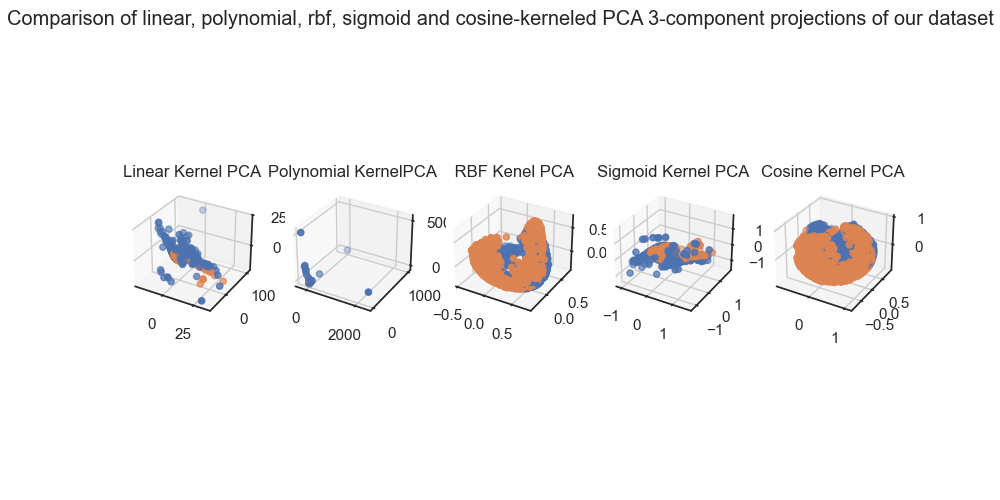

In [25]:
%matplotlib widget
sns.set(style='white', context='notebook', rc={'figure.figsize':(10,5)})
fig = plt.figure(4)
plt.suptitle('Comparison of linear, polynomial, rbf, sigmoid and cosine-kerneled PCA 3-component projections of our dataset')

## Linear Kernel
lin_kern_pca_ax_3 = fig.add_subplot(1,5,1, projection='3d')
lin_kern_pca_ax_3.scatter(
    lin_kern_pca_reduced_3[:, 0],
    lin_kern_pca_reduced_3[:, 1],
    lin_kern_pca_reduced_3[:, 2],
    c=[sns.color_palette()[x] for x in y])
lin_kern_pca_ax_3.set_title("Linear Kernel PCA")

## Polynomial Kernel
poly_kern_pca_ax_3 = fig.add_subplot(1,5,2, projection='3d')
poly_kern_pca_ax_3.scatter(
    poly_kern_pca_reduced_3[:, 0],
    poly_kern_pca_reduced_3[:, 1],
    poly_kern_pca_reduced_3[:, 2],
    c=[sns.color_palette()[x] for x in y])
poly_kern_pca_ax_3.set_title("Polynomial KernelPCA")

## RBF Kernel
rbf_kern_pca_ax_3 = fig.add_subplot(1,5,3, projection='3d')
rbf_kern_pca_ax_3.scatter(
    rbf_kern_pca_reduced_3[:, 0],
    rbf_kern_pca_reduced_3[:, 1],
    rbf_kern_pca_reduced_3[:, 2],
    c=[sns.color_palette()[x] for x in y])
rbf_kern_pca_ax_3.set_title(" RBF Kenel PCA")

## Sigmoid Kernel
sigm_kern_pca_ax_3 = fig.add_subplot(1,5,4, projection='3d')
sigm_kern_pca_ax_3.scatter(
    sigm_kern_pca_reduced_3[:, 0],
    sigm_kern_pca_reduced_3[:, 1],
    sigm_kern_pca_reduced_3[:, 2],
    c=[sns.color_palette()[x] for x in y])
sigm_kern_pca_ax_3.set_title("Sigmoid Kernel PCA")

## Cosine Kernel
cos_kern_pca_ax_3 = fig.add_subplot(1,5,5, projection='3d')
cos_kern_pca_ax_3.scatter(
    cos_kern_pca_reduced_2[:, 0],
    cos_kern_pca_reduced_2[:, 1],
    cos_kern_pca_reduced_3[:, 2],
    c=[sns.color_palette()[x] for x in y])
cos_kern_pca_ax_3.set_title("Cosine Kernel PCA")

plt.show()

## Write the data to be used in the next stage

UMAP and t-SNE are two heavy to be used for live inference, so I'm going to choose among the PCA reducers.

The one with the cosine Kernel seems to have potential, so I'll choose that one.

Now I have to choose how many components to use. I will produce many datasets and see with which one I get the best results when using KNN.

In [24]:
n_candidates = [1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 18, 21, 24, 30]
for n in n_candidates:
    cos_kern_pca_reducer_n = KernelPCA(n_components=n, kernel='cosine')
    cos_kern_pca_reduced_n = cos_kern_pca_reducer_n.fit_transform(scaled_X)

    cos_kern_pca_reduced_n_df = pd.DataFrame(cos_kern_pca_reduced_n)
    cos_kern_pca_reduced_n_df['class_numeric'] = ph2_data['class_numeric']
    cos_kern_pca_reduced_n_df.to_csv(ph3_labels_path+f'/cos_pca_{n}_reduced.csv', index=False)